In [29]:
import pandas as pd
import numpy as np
import dill

from imblearn.pipeline import make_pipeline
from imblearn.ensemble import EasyEnsemble, BalanceCascade
from imblearn.over_sampling import ADASYN

from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit, KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import auc, accuracy_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

## Combine data

First read and normalize the features.

In [30]:
features = pd.read_pickle('../pkl/11_features_engineered.pkl').dropna()

feat_cols = [x for x in features.columns if x not in ['date','location']]

features[feat_cols] = Normalizer().fit_transform(features[feat_cols])

Import the predictors.

In [31]:
framework_b_first = pd.read_pickle('../pkl/10_class_balancing_framework_b_first.pkl')
framework_b_max   = pd.read_pickle('../pkl/10_class_balancing_framework_b_max.pkl')

framework_a_first = pd.read_pickle('../pkl/10_class_balancing_framework_a_first.pkl')
framework_a_max   = pd.read_pickle('../pkl/10_class_balancing_framework_a_first.pkl')

In [32]:
framework_b_first.dtypes

location             object
date         datetime64[ns]
zika_bool             int64
dtype: object

In [33]:
print framework_b_first.shape, framework_b_first.isnull().sum().max()

fwd_b_first = pd.merge(framework_b_first, 
                       features, 
                       on=['date','location'], how='left').dropna()

print fwd_b_first.shape, fwd_b_first.isnull().sum().max()

print fwd_b_first.zika_bool.value_counts()

(1044, 3) 0
(658, 27) 0
1    331
0    327
Name: zika_bool, dtype: int64


In [34]:
#mask = framework_b_first.location.isin(features.location).pipe(np.invert)
#framework_b_first.loc[mask, 'location']

In [35]:
print framework_b_max.shape, framework_b_max.isnull().sum().max()

fwd_b_max = pd.merge(framework_b_max, 
                       features, 
                       on=['date','location'], how='left').dropna()

print fwd_b_max.shape, fwd_b_max.isnull().sum().max()

print fwd_b_max.zika_bool.value_counts()

(1044, 3) 0
(657, 27) 0
1    330
0    327
Name: zika_bool, dtype: int64


In [36]:
print framework_a_first.shape, framework_a_first.isnull().sum().max()

fwd_a_first = pd.merge(framework_a_first, 
                       features, 
                       on=['date','location'], how='left').dropna()

print fwd_a_first.shape, fwd_a_first.isnull().sum().max()

print fwd_a_first.zika_bool.value_counts()

(1605, 3) 0
(1143, 27) 0
1    949
0    194
Name: zika_bool, dtype: int64


In [37]:
print framework_a_max.shape, framework_a_max.isnull().sum().max()

fwd_a_max = pd.merge(framework_a_max, 
                       features, 
                       on=['date','location'], how='left').dropna()

print fwd_a_max.shape, fwd_a_max.isnull().sum().max()

print fwd_a_max.zika_bool.value_counts()

(1605, 3) 0
(1143, 27) 0
1    949
0    194
Name: zika_bool, dtype: int64


Split the data into train and test portions.

In [38]:
fbm_train, fbm_test = train_test_split(fwd_b_max,   test_size=0.30, random_state=42)
fbf_train, fbf_test = train_test_split(fwd_b_first, test_size=0.30, random_state=42)
fam_train, fam_test = train_test_split(fwd_a_max,   test_size=0.30, random_state=42)
faf_train, faf_test = train_test_split(fwd_a_first, test_size=0.30, random_state=42)

## Logistic regression

In [26]:
logistic_list = list()

for train,test,label in zip([fam_train, faf_train],
                            [fam_test,  faf_test],
                            ['Framework A, Max', 'Framework A, First']):
    
    Ytest = test['zika_bool']
    
    for penalty in ['l1','l2']:
        if penalty=='l1':
            LR = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear')
        else:
            LR = LogisticRegressionCV(Cs=10, penalty='l2')

        LR.fit(train[feat_cols], train['zika_bool'])
        Ypred = LR.predict(test[feat_cols])
        
        cm = confusion_matrix(Ytest, Ypred)
        f1 = f1_score(Ytest, Ypred)
        accuracy = accuracy_score(Ytest, Ypred)
        auc = roc_auc_score(Ytest, Ypred)
        
        Yplot = LR.predict_proba(test[feat_cols])[:,1]
        xdata, ydata, _ = roc_curve(Ytest, Yplot)
        #xdata, ydata, _ = roc_curve(train['zika_bool'], LR.predict(train[feat_cols]))
        
        df = pd.Series({'data':label, 'penalty':penalty,
                        'cm': cm, 'f1': f1, 
                        'accuracy':accuracy, 'auc':auc,
                        'roc_x': xdata, 'roc_y': ydata, 'model':LR})
        
        logistic_list.append(df)



In [27]:
logistic_results = (pd.concat(logistic_list, axis=1).T
                    .set_index(['data','penalty']))
logistic_results[['accuracy','f1','auc', 'cm']]

accuracy        f1       auc                    cm
data               penalty                                                    
Framework B, Max   l1       0.878788     0.875  0.878676  [[90, 12], [12, 84]]
                   l2       0.838384  0.836735  0.838848  [[84, 18], [14, 82]]
Framework B, First l1       0.762626  0.761421  0.764078  [[76, 19], [28, 75]]
                   l2       0.808081  0.820755  0.806541  [[73, 22], [16, 87]]
Framework A, Max   l1       0.862974  0.919932  0.686996  [[26, 38], [9, 270]]
                   l2       0.868805  0.923599   0.69058  [[26, 38], [7, 272]]
Framework A, First l1       0.862974  0.919932  0.686996  [[26, 38], [9, 270]]
                   l2       0.868805  0.923599   0.69058  [[26, 38], [7, 272]]

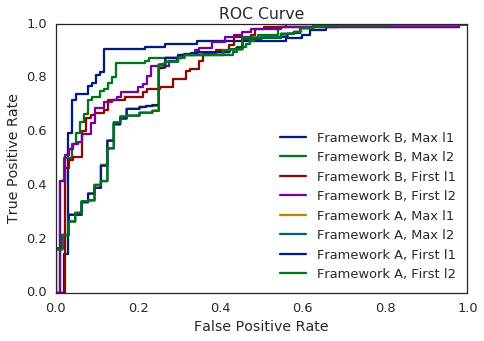

In [28]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

colors = sns.color_palette()

for idx,dat in logistic_results.iterrows():
    label = ' '.join(idx)
    xdata = dat.roc_x
    ydata = dat.roc_y
    ax.plot(xdata, ydata, label=label)

ax.legend(loc=0)

_ = ax.set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='ROC Curve')

plt.tight_layout()

## Random Forest Classifier

In [156]:
random_forest_list = list()

param_grid = {'max_depth':range(1,26), 'n_estimators':[100,200,300,400,500]}
RF = RandomForestClassifier(max_depth=8, n_jobs=-1, class_weight='balanced'
                            random_state=42, verbose=0, oob_score=True)

RFCV = GridSearchCV(RF, param_grid)
RFCV.fit(faf_train[feat_cols],  faf_train)
Ypred = RF.predict(test[feat_cols])


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 

In [157]:
random_forest_results = (pd.concat(random_forest_list, axis=1).T
                         .set_index('data'))
random_forest_results[['accuracy','f1','auc', 'cm']]

,accuracy,f1,auc,cm
data,,,,
"Framework B, Max",0.878788,0.878788,0.879596,"[[87, 15], [9, 87]]"
"Framework B, First",0.90404,0.909953,0.902862,"[[83, 12], [7, 96]]"
"Framework A, Max",0.886297,0.933333,0.731435,"[[31, 33], [6, 273]]"
"Framework A, First",0.886297,0.933333,0.731435,"[[31, 33], [6, 273]]"


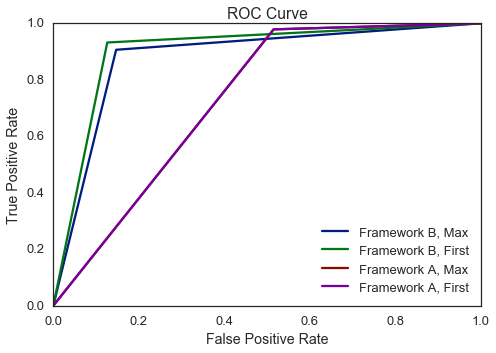

In [158]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

colors = sns.color_palette()

for idx,dat in random_forest_results.iterrows():
    label = idx
    xdata = dat.roc_x
    ydata = dat.roc_y
    ax.plot(xdata, ydata, label=label)

ax.legend(loc=0)

_ = ax.set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='ROC Curve')

plt.tight_layout()

## Linear SVM

In [94]:
svm_list = list()

for train,test,label in zip([fam_train, faf_train],
                            [fam_test,  faf_test],
                            ['Framework A, Max', 'Framework A, First']):
    
    for penalty in ['l1','l2']:
        dual=True
        if penalty == 'l1':
            dual=False
        
        max_f1 = 0
        for C in [1000, 100, 10, 1, 0.1, 0.01, 0.001]:
    
            Ytest = test['zika_bool']

            SVM = LinearSVC(penalty=penalty, loss='squared_hinge', C=C, dual=dual)

            SVM.fit(train[feat_cols], train['zika_bool'])
            Ypred = SVM.predict(test[feat_cols])

            cm = confusion_matrix(Ytest, Ypred)
            f1 = f1_score(Ytest, Ypred)
            accuracy = accuracy_score(Ytest, Ypred)
            auc = roc_auc_score(Ytest, Ypred)
            xdata, ydata, _ = roc_curve(Ytest, Ypred)
            
            if f1 > max_f1:
                df = pd.Series({'data':label, 'penalty':penalty, 'C':C,
                                'cm': cm, 'f1': f1, 
                                'accuracy':accuracy, 'auc':auc,
                                'roc_x': xdata, 'roc_y': ydata, 'model':RF})

        svm_list.append(df)

In [95]:
svm_results = (pd.concat(svm_list, axis=1).T
                         .set_index(['data','penalty','C']))
svm_results[['accuracy','f1','auc', 'cm']]

accuracy        f1       auc  \
data               penalty C                                     
Framework B, Max   l1      0.100  0.484848  0.653061       0.5   
                   l2      0.001  0.484848  0.653061       0.5   
Framework B, First l1      1.000  0.691919  0.705314  0.691211   
                   l2      0.100  0.479798  0.466321  0.481604   
Framework A, Max   l1      0.001  0.813411  0.897106       0.5   
                   l2      0.001  0.813411  0.897106       0.5   
Framework A, First l1      0.001  0.813411  0.897106       0.5   
                   l2      0.001  0.813411  0.897106       0.5   

                                                    cm  
data               penalty C                            
Framework B, Max   l1      0.100   [[0, 102], [0, 96]]  
                   l2      0.001   [[0, 102], [0, 96]]  
Framework B, First l1      1.000  [[64, 31], [30, 73]]  
                   l2      0.100  [[50, 45], [58, 45]]  
Framework A, Max   l1      0.001   [[0, 64], [0, 279]]  
                   l2      0.001   [[0, 64], [0, 279]]  
Framework A, First l1      0.001   [[0, 64], [0, 279]]  
                   l2      0.001   [[0, 64], [0, 279]]

## SVM with RBF

In [111]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

for train,test,label in zip([fam_train, faf_train],
                            [fam_test,  faf_test],
                            ['Framework A, Max', 'Framework A, First']):
    
    #cv = StratifiedShuffleSplit(train[feat_cols], n_iter=3, test_size=0.3, random_state=42)
    grid = GridSearchCV(SVC(), param_grid=param_grid)
    grid.fit(train[feat_cols], train['zika_bool'])
    
    print(label, grid.best_params_, grid.best_score_)

('Framework B, Max', {'C': 1000000.0, 'gamma': 0.10000000000000001}, 0.81045751633986929)
('Framework B, First', {'C': 10000000.0, 'gamma': 1.0}, 0.80869565217391304)


KeyboardInterrupt: 

In [114]:

svm_rbc_list = list()
for train,test,label in zip([fam_train, faf_train],
                            [fam_test,  faf_test],
                            ['Framework A, Max', 'Framework A, First']):
    
    if label == 'Framework B, Max':
        C_2d_range = [500000, 1000000, 5000000]
        gamma_2d_range = [0.05,  0.1,  0.5]
    else:
        C_2d_range = [5000000, 10000000, 50000000]
        gamma_2d_range = [0.5, 1.0, 5.0]
        
    for C in C_2d_range:
        for gamma in gamma_2d_range:
            clf = SVC(C=C, gamma=gamma)
            clf.fit(train[feat_cols], train['zika_bool'])

            Ypred = clf.predict(test[feat_cols])
            Ytest = test['zika_bool']

            cm = confusion_matrix(Ytest, Ypred)
            f1 = f1_score(Ytest, Ypred)
            accuracy = accuracy_score(Ytest, Ypred)
            auc = roc_auc_score(Ytest, Ypred)
            xdata, ydata, _ = roc_curve(Ytest, Ypred)
            
            if f1 > max_f1:
                df = pd.Series({'data':label, 'C':C, 'gamma':gamma,
                                'cm': cm, 'f1': f1, 
                                'accuracy':accuracy, 'auc':auc,
                                'roc_x': xdata, 'roc_y': ydata, 'model':clf})
                
            svm_rbc_list.append(df)


In [134]:
svm_rbc_results = pd.concat(svm_rbc_list, axis=1).T.set_index(['data','C','gamma'])
svm_rbc_results[['accuracy','f1','auc','cm']].groupby(level=0,as_index=False).apply(lambda x: x[x.f1==x.f1.max()])

,,,,accuracy,f1,auc,cm
,data,C,gamma,,,,
0,"Framework B, First",5000000,5.0,0.838384,0.836735,0.840164,"[[84, 11], [21, 82]]"
1,"Framework B, Max",5000000,0.1,0.858586,0.852632,0.85815,"[[89, 13], [15, 81]]"


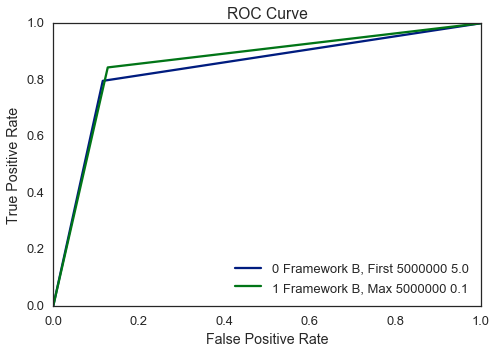

In [133]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

colors = sns.color_palette()

for idx,dat in svm_rbc_results.groupby(level=0,as_index=False).apply(lambda x: x[x.f1==x.f1.max()]).iterrows():
    label = ' '.join([str(x) for x in idx])
    xdata = dat.roc_x
    ydata = dat.roc_y
    ax.plot(xdata, ydata, label=label)

ax.legend(loc=0)

_ = ax.set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='ROC Curve')

plt.tight_layout()

## AdaBoost classification

In [150]:
ada_list = list()

for train,test,label in zip([fam_train, faf_train],
                            [fam_test,  faf_test],
                            ['Framework A, Max', 'Framework A, First']):

    # TODO check if this is the criterion I want
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500,
                            learning_rate=0.1, random_state=0)

    tree = tree.fit(train[feat_cols], train['zika_bool'])
    ada = ada.fit(train[feat_cols], train['zika_bool'])

    Ypred = ada.predict(test[feat_cols])
    Ytest = test['zika_bool']
    
    cm = confusion_matrix(Ytest, Ypred)
    f1 = f1_score(Ytest, Ypred)
    accuracy = accuracy_score(Ytest, Ypred)
    auc = roc_auc_score(Ytest, Ypred)
    xdata, ydata, _ = roc_curve(Ytest, Ypred)
    
    df = pd.Series({'data':label, 
    'cm': cm, 'f1': f1, 
    'accuracy':accuracy, 'auc':auc,
    'roc_x': xdata, 'roc_y': ydata, 'model':ada})
    
    ada_list.append(df)

In [151]:
ada_results = pd.concat(ada_list, axis=1).T.set_index('data')
ada_results[['accuracy','auc','f1','cm']]

,accuracy,auc,f1,cm
data,,,,
"Framework B, Max",0.858586,0.858762,0.85567,"[[87, 15], [13, 83]]"
"Framework B, First",0.863636,0.862391,0.872038,"[[79, 16], [11, 92]]"
"Framework A, Max",0.897959,0.774726,0.939341,"[[37, 27], [8, 271]]"
"Framework A, First",0.897959,0.774726,0.939341,"[[37, 27], [8, 271]]"


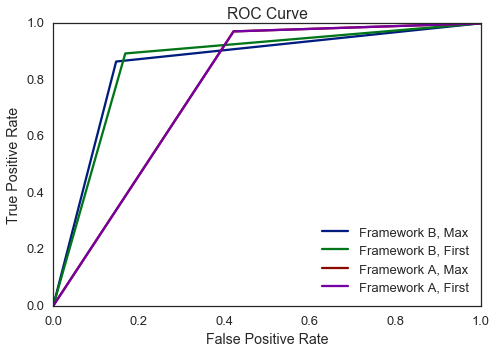

In [152]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

colors = sns.color_palette()

for idx,dat in ada_results.iterrows():
    label = idx
    xdata = dat.roc_x
    ydata = dat.roc_y
    ax.plot(xdata, ydata, label=label)

ax.legend(loc=0)

_ = ax.set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='ROC Curve')

plt.tight_layout()

## AdaBoost plus Imbalanced Learn

In [15]:
ada_list = list()

# TODO check if this is the criterion I want
adasyn = ADASYN()

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)

ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500,
                        learning_rate=0.1, random_state=0)

for train,test,label in zip([fam_train, faf_train],
                            [fam_test,  faf_test],
                            ['Framework A, Max', 'Framework A, First']):
    
    X_resampled, Y_resampled = adasyn.fit_sample(train[feat_cols], train['zika_bool'])

    tree = tree.fit(X_resampled, Y_resampled)
    ada = ada.fit(X_resampled, Y_resampled)

    Ypred = ada.predict(test[feat_cols])
    Ytest = test['zika_bool']
    
    cm = confusion_matrix(Ytest, Ypred)
    f1 = f1_score(Ytest, Ypred)
    accuracy = accuracy_score(Ytest, Ypred)
    auc = roc_auc_score(Ytest, Ypred)
    xdata, ydata, _ = roc_curve(Ytest, Ypred)
    
    df = pd.Series({'data':label, 
    'cm': cm, 'f1': f1, 
    'accuracy':accuracy, 'auc':auc,
    'roc_x': xdata, 'roc_y': ydata, 'model':ada})
    
    ada_list.append(df)

In [20]:
pd.Series(Y_resampled).value_counts()

0    671
1    670
dtype: int64

In [22]:
test['zika_bool'].value_counts()

1    279
0     64
Name: zika_bool, dtype: int64

In [16]:
ada_results = pd.concat(ada_list, axis=1).T.set_index('data')
ada_results[['accuracy','auc','f1','cm']]

,accuracy,auc,f1,cm
data,,,,
"Framework B, Max",0.858586,0.858762,0.85567,"[[87, 15], [13, 83]]"
"Framework B, First",0.863636,0.862391,0.872038,"[[79, 16], [11, 92]]"
"Framework A, Max",0.889213,0.823533,0.931655,"[[46, 18], [20, 259]]"
"Framework A, First",0.895044,0.833137,0.935252,"[[47, 17], [19, 260]]"
